In [84]:
NAME = "Michael Cornelisse"
STUDENT_NUMBER = "s1059020"
COLLABORATOR_NAME = "Nienke Helmers"
COLLABORATOR_STUDENT_NUMBER = "s1016904"

In [85]:
# import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import normalize
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn import tree
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from graphviz import Source
import xgboost as xgb
from xgboost import plot_tree
import seaborn as sns

In [86]:
PROJECT_ROOT_DIR = "."

def image_path(fig_id):
    return os.path.join(PROJECT_ROOT_DIR, "images", fig_id)

def save_fig(fig_id, tight_layout=True):
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(image_path(fig_id) + ".png", format='png', dpi=300)

In [87]:
# Load data
#actual_data = pd.read_csv('data/archive/actual.csv')
patient_data = pd.read_csv('data/archive/actual.csv', index_col = 'patient')
train_data = pd.read_csv('data/archive/data_set_ALL_AML_train.csv')
test_data = pd.read_csv('data/archive/data_set_ALL_AML_independent.csv')

In [88]:
# Clean all the data
# Drop the call collumns from both data sets
call_cols_train = [col for col in train_data.columns if 'call' in col]
train_data = train_data.drop(call_cols_train, axis = 1)

call_cols_test = [col for col in test_data.columns if 'call' in col]
test_data = test_data.drop(call_cols_test, axis = 1)

# Drop "Gene Description" and "Gene Accession Number"
cols_to_drop = ['Gene Description', 'Gene Accession Number']
train_data = train_data.drop(cols_to_drop, axis = 1)
test_data = test_data.drop(cols_to_drop, axis = 1)

# Transpose both data_sets
train_data = train_data.T
test_data = test_data.T

# now clean the patient_data
patient_data = patient_data.replace({'ALL': 0, 'AML': 1})
patient_train = patient_data[patient_data.index <= 38]
patient_test = patient_data[patient_data.index > 38]
# Define labels to use in our decission tree later.
patient_labels = ['ALL', 'AML']
# Make a seperate numpy array with our patient data, patient train data and patient test data
patient_data_np = patient_data.to_numpy()

In [89]:
# Show head patient data 0 = ALL, 1 = AML
patient_data.head()


,patient,cancer
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [90]:
print(patient_data.values.flatten())

[ 1  0  2  0  3  0  4  0  5  0  6  0  7  0  8  0  9  0 10  0 11  0 12  0
 13  0 14  0 15  0 16  0 17  0 18  0 19  0 20  0 21  0 22  0 23  0 24  0
 25  0 26  0 27  0 28  1 29  1 30  1 31  1 32  1 33  1 34  1 35  1 36  1
 37  1 38  1 39  0 40  0 41  0 42  0 43  0 44  0 45  0 46  0 47  0 48  0
 49  0 50  1 51  1 52  1 53  1 54  1 55  0 56  0 57  1 58  1 59  0 60  1
 61  1 62  1 63  1 64  1 65  1 66  1 67  0 68  0 69  0 70  0 71  0 72  0]


In [91]:
# Merge the test and training data set together
train_data = train_data.replace(np.inf, np.nan)
train_data = train_data.fillna(value = train_data.values.mean())

test_data = test_data.replace(np.inf, np.nan)
test_data = test_data.fillna(value = train_data.values.mean())

complete_data = train_data.append(test_data) # or train_data.append(test_data, ignore_index = True)
print(complete_data.shape)
complete_data

(72, 7129)


,0,1,2,3,4,5,6,7,8,9,...,7119,7120,7121,7122,7123,7124,7125,7126,7127,7128
1,-214,-153,-58,88,-295,-558,199,-176,252,206,...,185,511,-125,389,-37,793,329,36,191,-37
2,-139,-73,-1,283,-264,-400,-330,-168,101,74,...,169,837,-36,442,-17,782,295,11,76,-14
3,-76,-49,-307,309,-376,-650,33,-367,206,-215,...,315,1199,33,168,52,1138,777,41,228,-41
4,-135,-114,265,12,-419,-585,158,-253,49,31,...,240,835,218,174,-110,627,170,-50,126,-91
5,-106,-125,-76,168,-230,-284,4,-122,70,252,...,156,649,57,504,-26,250,314,14,56,-25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,-62,-198,-5,141,-256,-206,-298,-218,-14,100,...,92,532,-34,239,-78,707,354,-22,260,5
66,-58,-217,63,95,-191,-230,-86,-152,-6,-249,...,63,297,36,358,2,423,41,0,1777,-49
63,-161,-215,-46,146,-172,-596,-122,-341,171,-147,...,130,639,-27,548,-39,809,445,-2,210,16
64,-48,-531,-124,431,-496,-696,-1038,-441,235,157,...,84,1141,-121,197,-108,466,349,0,284,-73


In [66]:
# Dimensionality reduction PCA
pca = PCA()
pca_data = pca.fit_transform(complete_data)

#print(print(pca.explained_variance_ratio_))
pca_variance_ratio = pca.explained_variance_ratio_.cumsum()
pca_variance_percentage = pca_variance_ratio*100

There are 33 attributes that together explain 90% of the variance.


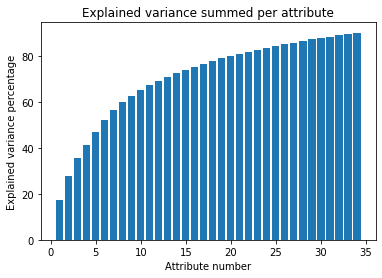

Figure: A plot of the explained variance. The variance is summed for all attributes up to and including
the current attribute number,for examplethe tenth attribute shows the sum of attributes 1 to 10.


In [69]:
#Calculate and plot explained variance PCA
pca_variance_ratio = pca.explained_variance_ratio_.cumsum()
pca_variance_percentage = pca_variance_ratio * 100
plt.bar(range(1,pca_variance_percentage.size+1), pca_variance_percentage)
plt.title("Explained variance summed per attribute")
plt.xlabel("Attribute number")
plt.ylabel("Explained variance percentage")
plt.show()
print('''Figure: A plot of the explained variance. The variance is summed for all attributes up to and including
the current attribute number,for examplethe tenth attribute shows the sum of attributes 1 to 10.''')

#Determine number of attributes needed for an explained variance of 90%
pca_variance_cropped = [i for i in pca_variance_percentage if i < 90]
no_attributes = len(pca_variance_cropped)
print("There are {} attributes that together explain 90% of the variance." .format(no_attributes))

In [33]:
pca.n_components_ 

72

In [72]:
#Crop pca_data
pca_data = np.delete(pca_data, slice(no_attributes, len(pca_data)) , 1)

#Split data back to original train and test split
pca_train = pca_data[:38]
pca_test = pca_data[38:]

print(pca_test)

[[ 23228.24839305 -10207.1420217  -24864.18347267 ...  -9319.00780465
     710.72707006   3173.19072395]
 [  7327.1074105   -8114.5435845   -9592.57862468 ...  -2761.94674844
     807.26760658   2135.51830256]
 [ -5088.3671856   -2548.71711692 -21366.13238222 ...  -1459.48009382
  -12716.26586577   2585.69213968]
 ...
 [-32735.95962863  49989.95602441 -14717.92574639 ...  -3286.94179133
     965.4907633  -15286.94317236]
 [ 13203.04043613  22955.40134478  12673.4899502  ...   6706.94312697
     622.4353914    -110.32838347]
 [ 23688.92717743  59098.56222497  -9244.34665965 ...   1193.62829955
     614.03557026  -4298.09975531]]


In [35]:

def plot_classification_error(start, stop, step, accuracy_mean_train, accuracy_mean_test, function):
    plt.plot(range(start,stop, step), (1-accuracy_mean_train), label='accuracy train set')
    plt.plot(range(start,stop, step), (1-accuracy_mean_test), label='accuracy test set')
    plt.legend()
    plt.xlabel('Maximum {}'.format(function))
    plt.ylabel('Classification error')
    plt.title('Classification error of a decision tree as function of {}'.format(function))
    plt.show()

def k_fold(folds, start, stop, step, method):
    kf = KFold(n_splits=folds)
    accuracy_mean_train = np.array([])
    accuracy_mean_test = np.array([])           
    for i in range(start, stop, step):
        accuracy_train = np.array([])
        accuracy_test = np.array([])
        for train, test in kf.split(pca_data, patient_data):
            
            if(method == 'tree'):
                split_clf = tree.DecisionTreeClassifier(criterion='gini', max_depth = i)
                split_clf = split_clf.fit(pca_data[train], patient_data_np[train])
                accuracy_train = np.append(
                    accuracy_train, metrics.accuracy_score(patient_data_np[train], split_clf.predict(pca_data[train])))
                accuracy_test = np.append(
                    accuracy_test, metrics.accuracy_score(patient_data_np[test], split_clf.predict(pca_data[test]))) 
            
            elif(method == 'rf'):
                rf = RandomForestClassifier(n_estimators = 100, criterion='gini', max_depth = i)
                rf = rf.fit(pca_data[train], patient_data_np[train])
                accuracy_train = np.append(
                    accuracy_train, metrics.accuracy_score(patient_data_np[train], rf.predict(pca_data[train])))
                accuracy_test = np.append(
                    accuracy_test, metrics.accuracy_score(patient_data_np[test], rf.predict(pca_data[test]))) 
                
            elif(method == 'rf_estimators'):
                    rf = RandomForestClassifier(n_estimators = i, criterion='gini', max_depth = 4)
                    rf = rf.fit(pca_data[train], patient_data_np[train])
                    accuracy_train = np.append(
                        accuracy_train, metrics.accuracy_score(patient_data_np[train], rf.predict(pca_data[train])))
                    accuracy_test = np.append(
                        accuracy_test, metrics.accuracy_score(patient_data_np[test], rf.predict(pca_data[test]))) 
                
        accuracy_mean_train = np.append(accuracy_mean_train, np.mean(accuracy_train))
        accuracy_mean_test = np.append(accuracy_mean_test, np.mean(accuracy_test))
    return accuracy_mean_train, accuracy_mean_test

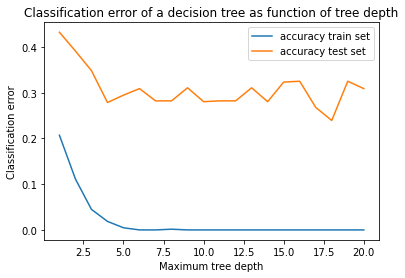

In [36]:
accuracy_mean_train_tree, accuracy_mean_test_tree = k_fold(10, 1, 21, 1, 'tree')
plot_classification_error(1, 21, 1, accuracy_mean_train_tree, accuracy_mean_test_tree, 'tree depth')

In [73]:
# Fit the actual decision tree
# firstly we will fit the tree with the gini criterion
tree_clf = tree.DecisionTreeClassifier(criterion='gini', max_depth = 4)
tree_clf = tree_clf.fit(pca_train, patient_train)
prediction=tree_clf.predict(pca_test)
accuracy = metrics.accuracy_score(patient_test, prediction)
print("The standard decision tree has an accuracy of {} and an error rate of {}.".format(accuracy, 1-accuracy))

The standard decision tree has an accuracy of 0.5588235294117647 and an error rate of 0.4411764705882353.


In [18]:
from graphviz import Source
def plot_tree_graph(inp, start, stop):
    dot_data = export_graphviz(inp, out_file=None, 
                               feature_names=range(1,34),  
                               class_names=patient_labels,
                               rounded=True,
                               filled=True)
    # Draw graph
    graph = Source(dot_data, format="png") 
    return graph

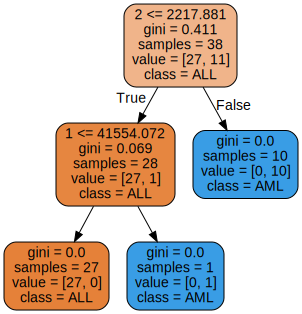

In [43]:
# Now we will show the decision tree with gini criterion 
graph = plot_tree_graph(tree_clf, 1, 34)
graph

In [71]:
test_score1 = tree_clf.score(pca_train, patient_train.values.flatten())
print(test_score1)
accuracy = metrics.accuracy_score(patient_test, tree_clf.predict(pca_test))
print("The standard decision tree with gini has an accuracy of {} and an error rate of {}.".format(accuracy, 1-accuracy))

1.0
The standard decision tree with gini has an accuracy of 0.5294117647058824 and an error rate of 0.47058823529411764.


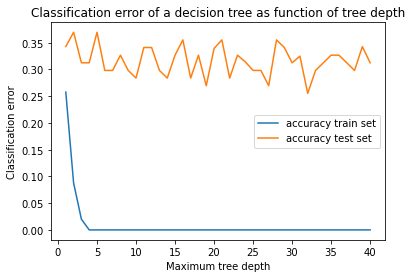

In [45]:
# Classification Random Forrest
rf = RandomForestClassifier(n_estimators = 10, criterion='gini', max_depth = 10)
rf.fit(pca_train, patient_train.values.flatten())

accuracy = metrics.accuracy_score(patient_test, rf.predict(pca_test))
error = 1-accuracy

accuracy_mean_train = np.array([])
accuracy_mean_test = np.array([])

patient_data_np = patient_data_np.ravel()

# Plot accuracy test and train
accuracy_mean_train_rf, accuracy_mean_test_rf = k_fold(10, 1, 41, 1, 'rf')
plot_classification_error(1, 41, 1, accuracy_mean_train_rf, accuracy_mean_test_rf, 'tree depth')

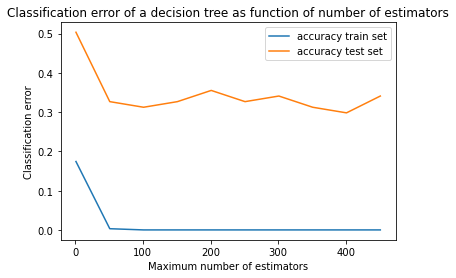

In [46]:
#Plot accuracy test and train for number of estimators
accuracy_mean_train_estimator, accuracy_mean_test_estimator = k_fold(10, 1, 501, 50, 'rf_estimators')
plot_classification_error(1, 501, 50, accuracy_mean_train_estimator, accuracy_mean_test_estimator, 'number of estimators')

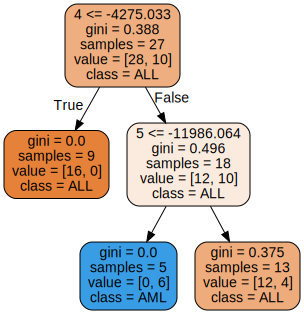

In [47]:
#visualisation random forest classifier
rf = RandomForestClassifier(n_estimators = 100,max_features = 'sqrt', criterion='gini', max_depth = 2)
rf = rf.fit(pca_train, patient_train.values.flatten())

estimator = rf.estimators_[99]

graph_rf = plot_tree_graph(estimator,1, 34)

graph_rf


In [48]:
# Use the forest's predict method on the test data
test_score = rf.score(pca_train, patient_train.values.flatten())
print(test_score)
accuracy = metrics.accuracy_score(patient_test, rf.predict(pca_test))
print("The Random forrest has an accuracy of {} and an error rate of {}.".format(accuracy, 1-accuracy))

0.9736842105263158
The Random forrest has an accuracy of 0.6176470588235294 and an error rate of 0.38235294117647056.


(38, 33)


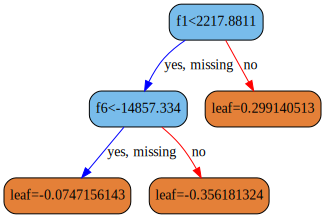

In [22]:
# Classification Gradient Boost
print(pca_train.shape)
#print(patient_train_np)
#df = pd.DataFrame(pca_train, index=pca_train[:,0])
#p = pd.DataFrame(patient_train_np)
#print(df)
#pd.DataFrame(d['data'],columns=d['feature_names']),d['target']
xb = xgb.XGBClassifier(n_estimators = 1000, max_depth = 4, eval_metric='error', use_label_encoder=False)
xb = xb.fit(pca_train, patient_train.values.flatten())

#print(xb.get_booster().get_dump())

#fig, ax = plt.subplots(figsize=(10, 10))
#xgb.plot_tree(xb.get_booster(), num_trees=4, ax=ax)
#plt.show()

cd = {'shape': 'box',
 'style': 'filled,rounded',
 'fillcolor': '#78bceb'}

lf = {'shape': 'box',
 'style': 'filled, rounded',
 'fillcolor': '#e48038'}

xgb.to_graphviz(xb,condition_node_params = cd, leaf_node_params = lf, num_trees=2, feature_names= "test")

#estimator = rf.get_booster().get_dump()

#graph_rf = plot_tree_graph(xb, 1, 34)

#graph_rf
#print (estimator)


In [49]:
accuracy = metrics.accuracy_score(patient_test, xb.predict(pca_test))

print("The XGBoost has an accuracy of {} and an error rate of {}.".format(accuracy, 1-accuracy))

The XGBoost has an accuracy of 0.5882352941176471 and an error rate of 0.4117647058823529.
